In [1]:
import json
from datetime import datetime, timedelta
import pathlib
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from statistics import median, mean
from itertools import combinations
from minepy import MINE
import warnings
warnings.simplefilter("ignore", UserWarning)
from sklearn.metrics import mutual_info_score

In [2]:
# load traces
relativePathToData = 'data/sequential_data'

pathToData = pathlib.Path().absolute().parent / relativePathToData
pathToTraces = pathToData / 'traces'

def loadJson(link):
    with open(link) as f:
        data = json.load(f)
    return data

operations = sorted(list(map(lambda x: x.name, list(pathToTraces.glob('**'))[1:])))

traces = {}
for operation in operations:
    pathToOperation = pathToTraces / operation
    pathes = sorted(list(pathToOperation.glob('*.json')))
    traces[operation] = {}
    traces[operation]['id'] = list(map(lambda x: x.name[:x.name.find('.json')], pathes))
    traces[operation]['data'] = list(map(lambda x: loadJson(x), pathes))

In [3]:
# load metrics
pathToMetrics = pathToData / 'fixed_metrics'
nodeNames = sorted(list(map(lambda x: x.name[:x.name.find('_')], list(pathToMetrics.glob('*.csv')))))

nodes = {}
for name in nodeNames:
    nodes[name] = {}
    nodes[name]['data'] = pd.read_csv(pathToMetrics / (name + '_metrics.csv'))

for name in nodeNames:
    nodes[name]['data']['now'] = nodes[name]['data']['now'].map(
        lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S CEST'))

metrics = list(nodes[nodeNames[0]]['data'].keys())
metrics.remove('now')
metrics.remove('load.cpucore')  # always == 8
metrics = sorted(metrics)

In [4]:
# parse of json data to graph
def parseTrace(operation, df, graph):
    G = graph
    for item in df['children']:
        trace = {}
        trace['operation'] = operation
        trace['host'] = item.get('info').get('host') 
        trace['name'] = item.get('info').get('name')
        trace['service'] = item.get('info').get('service')
        trace['project'] = item.get('info').get('project') 
        trace['startTimestamp'] = datetime.strptime(item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-start').get('timestamp'), '%Y-%m-%dT%H:%M:%S.%f')
        endTimestamp = item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-stop', {'timestamp': 'Null'}).get('timestamp') 
        if endTimestamp != 'Null':
            trace['endTimestamp'] = datetime.strptime(endTimestamp, '%Y-%m-%dT%H:%M:%S.%f')
            trace['duration'] = trace['endTimestamp'] - trace['startTimestamp']
        else: 
            trace['endTimestamp'] = 'Null'
            trace['duration'] = 'Null'
        trace['trace_id'] = item.get('trace_id') 
        trace['parent_id'] = item.get('parent_id') 
        trace['base_id'] = item.get('info').get('meta.raw_payload.' + item['info']['name'] + '-start').get('base_id')
        trace['isRoot'] = trace['parent_id'] == trace['base_id']
        
        G.add_nodes_from([(trace['trace_id'], trace)])
        if not(trace['isRoot']):
            G.add_edge(trace['parent_id'], trace['trace_id'])
        
        if len(item['children']) != 0:
            G = parseTrace(operation, item, G)
    
    return G

for operation in operations:
    traces[operation]['graph'] = list(map(lambda x: parseTrace(operation, x, nx.DiGraph()), traces[operation]['data']))

In [5]:
# fix non-endTimestamp problem
for operation in operations:
    for trace in traces[operation]['graph']:
        spans = trace.nodes(data = True)
        for span in spans:
            if span[1]['endTimestamp'] == 'Null':
                children = list(nx.descendants(trace, span[0]))
                if children == []:
                    continue
                endTimestamp = span[1]['startTimestamp']
                for child in children:
                    time = spans[child]['endTimestamp']
                    if time != 'Null':
                        endTimestamp = max(endTimestamp, time)
                span[1]['endTimestamp'] = endTimestamp
                span[1]['duration'] = span[1]['endTimestamp'] - span[1]['startTimestamp']

In [6]:
# example of trace
print(json.dumps(traces[operations[2]]['data'][57], indent=2))

{
  "info": {
    "started": 0,
    "last_trace_started": 37,
    "finished": 289,
    "name": "total"
  },
  "stats": {
    "wsgi": {
      "count": 2,
      "duration": 285
    },
    "db": {
      "count": 7,
      "duration": 6
    }
  },
  "children": [
    {
      "info": {
        "exception": "None",
        "name": "wsgi",
        "service": "public",
        "started": 0,
        "meta.raw_payload.wsgi-stop": {
          "info": {
            "host": "wally113"
          },
          "name": "wsgi-stop",
          "service": "public",
          "timestamp": "2019-11-19T20:20:31.579399",
          "trace_id": "90a44bef-8103-4ec6-85e8-e4ead42c999b",
          "project": "keystone",
          "parent_id": "0d338b53-389d-49d0-ae76-816ca0c46a79",
          "base_id": "0d338b53-389d-49d0-ae76-816ca0c46a79"
        },
        "finished": 1,
        "project": "keystone",
        "host": "wally113",
        "meta.raw_payload.wsgi-start": {
          "info": {
            "host": "wal

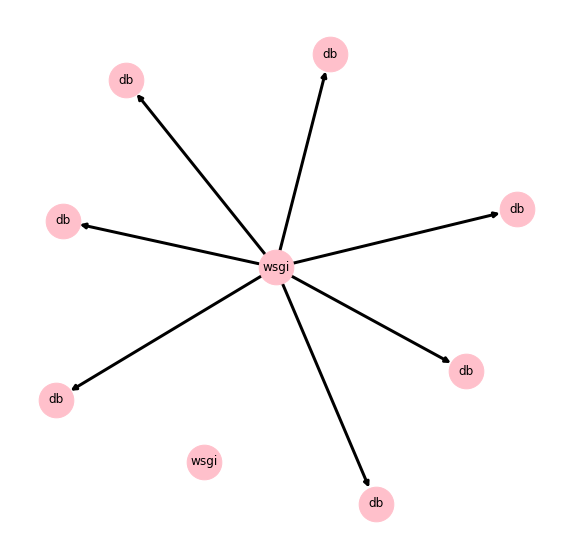

In [7]:
# example of this trace like a graph
g = traces[operations[2]]['graph'][57]
plt.figure(figsize=(10, 10)) 
pos = nx.spring_layout(g)
nx.draw_networkx_labels(g, pos, nx.get_node_attributes(g, 'name'))
nx.draw(g, pos = pos, node_color = 'pink', node_size = 1200, font_size = 14, width = 3)
plt.show()

In [8]:
# create windowing
windowSize = 60
overlapping = 0
#overlapping = 0.25
n_s = int(windowSize * (1 - overlapping))
windows = []

timeStart = datetime.strptime('2019-11-19 17:38:38', '%Y-%m-%d %H:%M:%S')
timeEnd = datetime.strptime('2019-11-20 01:30:00', '%Y-%m-%d %H:%M:%S')

time = timeStart
while time + timedelta(seconds=windowSize) <= timeEnd:
    windows.append([time + timedelta(seconds=1), time + timedelta(seconds=windowSize)])
    time += timedelta(seconds=n_s)

ds = pd.DataFrame({'window': windows})

In [9]:
# create label from features
def combineLabel(features, combination):
    label = features[0]
    for i in combination:
        label = label + '_' + features[i]
    return label

# create JSON of all modes
features_p = ['host_1', 'operation_1', 'name_1', 'service_1', 'project_1']
features = ['host_2', 'operation_2', 'name_2', 'service_2', 'project_2']
featuresNonCommunication = ['host', 'operation', 'name', 'service', 'project']
columns = []
columns.append(featuresNonCommunication[0])
columns.append(features_p[0] + '->' + features[0])
for l in range(1, len(features)):
    for combination in combinations(list(range(1, len(features))), l):
        label_r = combineLabel(featuresNonCommunication, list(combination))
        columns.append(label_r)
        label_r = combineLabel(features, list(combination))
        if len(features_p) != 0:
            label_l = combineLabel(features_p, list(combination))
            columns.append(label_l + '->' + label_r)

modes = {}
for i in range(len(columns)):
    k = (i // 2 + 1, i // 2 + 17)[i % 2]
    modes[k] = { 'name': columns[i], 'combinations': [] }

In [10]:
# create columns

def addCombinationToMode(i, label):
    k = (i // 2 + 1, i // 2 + 17)[i % 2]
    if label not in modes.get(k).get('combinations'):
        modes[k]['combinations'].append(label)
        modes[k]['combinations'].append(label + '__duration')

def addCombintaionToColumns(label):
    if label not in list(ds.keys()):
        ds[label] = 0
        ds[label + '__duration'] = 0
    
# get all possible combinations of two types of aggregation
for operation in operations:
    for trace in traces[operation]['graph']:
        spans = trace.nodes(data = True)
        for span in spans:
            i = 0
            features_p = []
            if not(span[1]['isRoot']):
                span_p = spans[list(trace.predecessors(span[0]))[0]]
                features_p = [span_p['host'], span_p['operation'], span_p['name'], span_p['service'], span_p['project']]
            features = [span[1]['host'], span[1]['operation'], span[1]['name'], span[1]['service'], span[1]['project']]
            addCombintaionToColumns(features[0])
            addCombinationToMode(i, features[0])
            i += 1
            if len(features_p) != 0:
                addCombintaionToColumns(features_p[0] + '->' + features[0])
                addCombinationToMode(i, features_p[0] + '->' + features[0])
            i += 1
            for l in range(1, len(features)):
                for combination in combinations(list(range(1, len(features))), l):
                    label_r = combineLabel(features, list(combination))
                    addCombintaionToColumns(label_r)
                    addCombinationToMode(i, label_r)
                    i += 1
                    if len(features_p) != 0:
                        label_l = combineLabel(features_p, list(combination))
                        addCombintaionToColumns(label_l + '->' + label_r)
                        addCombinationToMode(i, label_l + '->' + label_r)
                    i += 1

# save JSON of modes
with open(pathToTraces / 'modes.json', 'w') as f:
    json.dump(modes, f)

# Metrics columns
for metric in metrics:
    for name in nodeNames:
        ds[name + '_' + metric] = 0.0
        
# MI columns
for p in range(len(metrics)):
    for l in range(p, len(metrics)):
        for i in range(len(nodeNames)):
            t = (0, 1)[p == l]
            for j in range(i + t, len(nodeNames)):
                ds['MI' + '_' + nodeNames[i] + '_' + metrics[p] + '_' + nodeNames[j] + '_' + metrics[l]] = 0.0

In [11]:
# all modes
print(json.dumps(modes, indent=2))

{
  "1": {
    "name": "host",
    "combinations": [
      "wally113",
      "wally113__duration",
      "wally122",
      "wally122__duration",
      "wally124",
      "wally124__duration",
      "wally117",
      "wally117__duration"
    ]
  },
  "17": {
    "name": "host_1->host_2",
    "combinations": [
      "wally113->wally113",
      "wally113->wally113__duration",
      "wally113->wally122",
      "wally113->wally122__duration",
      "wally122->wally113",
      "wally122->wally113__duration",
      "wally122->wally122",
      "wally122->wally122__duration",
      "wally113->wally124",
      "wally113->wally124__duration",
      "wally124->wally113",
      "wally124->wally113__duration",
      "wally124->wally124",
      "wally124->wally124__duration",
      "wally113->wally117",
      "wally113->wally117__duration",
      "wally117->wally113",
      "wally117->wally113__duration",
      "wally117->wally117",
      "wally117->wally117__duration"
    ]
  },
  "2": {
    "name": 

In [12]:
# compute median of metric
f = 0
k = 0
while f < len(windows):
    for metric in metrics:
        for name in nodeNames:
            m = median(list(nodes[name]['data'][metric])[k:k + windowSize])
            #m = mean(list(nodes[name]['data'][metric])[k:k + windowSize])
            ds.at[f, name + '_' + metric] = m
    k += n_s
    f += 1

In [13]:
# compute MI
f = 0
k = 0
while f < len(windows):
    for p in range(len(metrics)):
        for l in range(p, len(metrics)):
            for i in range(len(nodeNames)):
                t = (0, 1)[p == l]
                for j in range(i + t, len(nodeNames)):
                    mi = mutual_info_score(list(nodes[nodeNames[i]]['data'][metrics[p]])[k:k + windowSize],
                                           list(nodes[nodeNames[j]]['data'][metrics[l]])[k:k + windowSize])
                    #mine = MINE(alpha=0.6, c=15, est="mic_approx")
                    #mine.compute_score(list(nodes[nodeNames[i]]['data'][metrics[p]])[k:k + windowSize],
                    #                   list(nodes[nodeNames[j]]['data'][metrics[l]])[k:k + windowSize])
                    #mi = mine.mic()
                    ds.at[f, 'MI' + '_' + nodeNames[i] + '_' + metrics[p] + '_' + nodeNames[j] + '_' + metrics[
                        l]] = mi
    k += n_s
    f += 1

In [14]:
# collect data

# find index of window
def findIndex(time):
    for i in range(len(windows)):
        if windows[i][0] <= time < (windows[i][1] + timedelta(seconds=1)):
            return i
    return -1

def increaseNumberAndDuration(row, column, duration):
    ds.at[row, column + '__duration'] += duration
    ds.at[row, column] += 1
    
def fillWindow(i_s, i_e, span, column):
    if (i_s == i_e):
        increaseNumberAndDuration(i_s, column, (span['endTimestamp'] - span['startTimestamp']) // timedelta(microseconds = 1))
    else:
        if (i_e == -1):
            increaseNumberAndDuration(i_s, column, (windows[i_s][1] + timedelta(seconds=1) - span['startTimestamp']) // timedelta(microseconds = 1))
        else:
            increaseNumberAndDuration(i_s, column, (windows[i_s][1] + timedelta(seconds=1) - span['startTimestamp']) // timedelta(microseconds = 1))
            increaseNumberAndDuration(i_e, column, (span['endTimestamp'] - windows[i_e][0]) // timedelta(microseconds = 1))
            for i in range(1, i_e - i_s):
                increaseNumberAndDuration(i_s + i, column, (windows[i_s + i][1] + timedelta(seconds=1) - windows[i_s + i][0]) // timedelta(microseconds = 1))
    
for operation in operations:
    for trace in traces[operation]['graph']:
        spans = trace.nodes(data = True)
        for span in spans:
            i_s, i_e = findIndex(span[1]['startTimestamp']), -1
            if span[1]['endTimestamp'] != 'Null':
                i_e = findIndex(span[1]['endTimestamp'])
            features = [span[1]['host'], span[1]['operation'], span[1]['name'], span[1]['service'], span[1]['project']]
            fillWindow(i_s, i_e, span[1], features[0])
            features_p = []
            if not(span[1]['isRoot']):
                span_p = spans[list(trace.predecessors(span[0]))[0]]
                features_p = [span_p['host'], span_p['operation'], span_p['name'], span_p['service'], span_p['project']]
            if len(features_p) != 0:
                fillWindow(i_s, i_e, span[1], features_p[0] + '->' + features[0])
            for l in range(1, len(features)):
                for combination in combinations(list(range(1, len(features))), l):
                    label_r = combineLabel(features, list(combination))
                    fillWindow(i_s, i_e, span[1], label_r)
                    if len(features_p) != 0:
                        label_l = combineLabel(features_p, list(combination))
                        fillWindow(i_s, i_e, span[1], label_l + '->' + label_r)

In [15]:
ds

,window,wally113,wally113__duration,wally113_boot_delete,wally113_boot_delete__duration,wally113_wsgi,wally113_wsgi__duration,wally113_public,wally113_public__duration,wally113_keystone,...,MI_wally113_mem.used_wally117_mem.used,MI_wally113_mem.used_wally122_mem.used,MI_wally113_mem.used_wally123_mem.used,MI_wally113_mem.used_wally124_mem.used,MI_wally117_mem.used_wally122_mem.used,MI_wally117_mem.used_wally123_mem.used,MI_wally117_mem.used_wally124_mem.used,MI_wally122_mem.used_wally123_mem.used,MI_wally122_mem.used_wally124_mem.used,MI_wally123_mem.used_wally124_mem.used
0,"[2019-11-19 17:38:39, 2019-11-19 17:39:38]",1661,117992527,0,0,184,111443028,704,11928666,704,...,4.094345,4.071240,4.094345,4.094345,4.071240,4.094345,4.094345,4.071240,4.071240,4.094345
1,"[2019-11-19 17:39:39, 2019-11-19 17:40:38]",1700,142804782,0,0,209,136233748,466,11050578,466,...,4.094345,4.094345,4.071240,4.094345,4.094345,4.071240,4.094345,4.071240,4.094345,4.071240
2,"[2019-11-19 17:40:39, 2019-11-19 17:41:38]",1382,145511020,0,0,178,143442043,360,9061286,360,...,4.094345,4.094345,4.048135,4.094345,4.094345,4.048135,4.094345,4.048135,4.094345,4.048135
3,"[2019-11-19 17:41:39, 2019-11-19 17:42:38]",1435,141913054,0,0,181,138884166,401,9534068,401,...,4.048135,4.025030,4.048135,4.071240,4.025030,4.048135,4.071240,4.025030,4.048135,4.071240
4,"[2019-11-19 17:42:39, 2019-11-19 17:43:38]",1712,139937220,0,0,219,134762190,450,11454702,450,...,4.094345,4.094345,4.094345,4.094345,4.094345,4.094345,4.094345,4.094345,4.094345,4.094345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,"[2019-11-20 01:24:39, 2019-11-20 01:25:38]",0,0,0,0,0,0,0,0,0,...,4.071240,4.025030,4.071240,4.048135,4.048135,4.094345,4.071240,4.048135,4.025030,4.071240
467,"[2019-11-20 01:25:39, 2019-11-20 01:26:38]",0,0,0,0,0,0,0,0,0,...,3.970099,3.993204,3.970099,3.970099,4.071240,4.048135,4.048135,4.071240,4.071240,4.048135
468,"[2019-11-20 01:26:39, 2019-11-20 01:27:38]",0,0,0,0,0,0,0,0,0,...,4.048135,4.025030,4.025030,3.978820,4.071240,4.071240,4.025030,4.048135,4.001925,4.001925
469,"[2019-11-20 01:27:39, 2019-11-20 01:28:38]",0,0,0,0,0,0,0,0,0,...,4.094345,4.094345,4.094345,4.071240,4.094345,4.094345,4.071240,4.094345,4.071240,4.071240


In [16]:
# save data
title = ('non', str(int(overlapping * 100)) + '%')[overlapping != 0]

ds.to_csv(pathToTraces / ('parsed_traces_with_' + title + '_overlapping.csv'), index=False)